#Proyecto final IA#
####Realizado por: Juan Martin Sanchez, Esteban Alvarado y Carlos Montiel

###Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import keras
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import cv2

from sklearn.model_selection import GridSearchCV,KFold
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

###Dataset Load

Se carga dataset y se separa en imagenes/etiquetas de entrenamiento y imagenes/etiquetas de testeo.

In [ ]:
(X_train, y_train), (X_test, y_test)=tf.keras.datasets.mnist.load_data(path="mnist.npz")

Visualizacion de imagen con index=5 para dar ejemplo.

LABEL (number): 2

IMAGE PIXEL ARRAY:
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  13  25 100 122   7   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  33 151 208 252 252 252 146   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  40 152 244 252 253 224 211 252 232  40   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  15

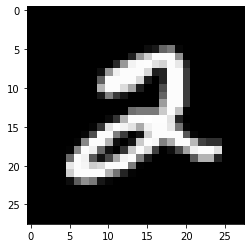

In [ ]:
index = 5
# Set number of characters per row when printing
np.set_printoptions(linewidth=320)

# Print the label and image
print(f'LABEL (number): {y_train[index]}')
print(f'\nIMAGE PIXEL ARRAY:\n {X_train[index]}')
plt.imshow(X_train[index], cmap='gray', vmin=0, vmax=255)


Normalizacion de imagenes al escalar valores del 0 al 1, es decir dividir todo para 255.

In [ ]:
X_train  = X_train/ 255.0
X_test = X_test / 255.0
X_train  = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
X_train.shape

(60000, 28, 28, 1)

Creacion de red neuronal convolusional 

In [ ]:
def create_cnn_model(n_nodes=64, activation='relu'):
    model = Sequential()
    model.add(Conv2D(28,(3,3),activation=activation,input_shape=(28,28,1)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(n_nodes,(3,3),activation=activation))
    model.add(MaxPooling2D((2,2),padding='same'))
    model.add(Conv2D(n_nodes,(3,3),activation=activation))
    model.add(Flatten())
    model.add(Dense(n_nodes,activation=activation))
    model.add(Dense(10, activation='softmax'))  
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

Creacion de GridSearch para optimizacion de Hyperparametros, se incluye con KFOLD CV que tiene 5 splits.

In [ ]:

model = KerasClassifier(build_fn=create_cnn_model, verbose=1)

param_grid = { 

    'activation':['relu','sigmoid','tanh'],
}
#Se hace un gridSearch con un CV igual a 5 con el fin de validar los parametros
kfold = KFold(n_splits=5, shuffle=True, random_state=12345)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_search=grid.fit(X_train,y_train)
print(grid_search.best_params_)

<ipython-input-25-88fcfbe0ba0d>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_model, verbose=1)
/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


1875/1875 [==============================] - 7s 3ms/step - loss: 0.1350 - accuracy: 0.9583
{'activation': 'relu'}


In [ ]:
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)
cnn = create_cnn_model()
cnn.summary()
history = cnn.fit(
    X_train,
    y_train,
    epochs=30,
    validation_data=(X_test,y_test),  
    batch_size=32,
    callbacks=[early_stop]
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 28)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 11, 11, 64)        16192     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_5 (Flatten)         (None, 1024)             

Graficacion de accuracy

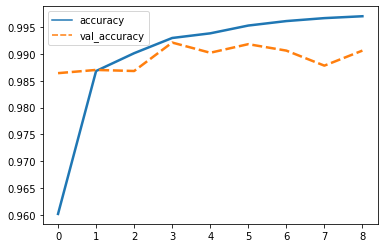

In [ ]:
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);

Grafico de Loss:

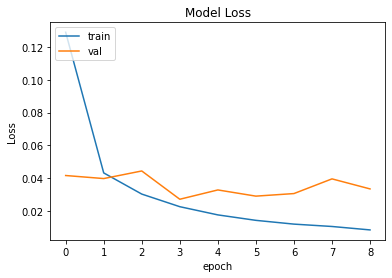

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Con Data Augmentation: 

In [ ]:
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)
cnnAg = create_cnn_model()
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False, 
        fill_mode='constant', cval = 0.0)

datagen.fit(X_train)
history = cnnAg.fit_generator(datagen.flow(X_train,y_train, batch_size=32),
                                  epochs = 30, 
                                  validation_data = (X_test,y_test),
                                  verbose = 1,
                                  steps_per_epoch = X_train.shape[0] / 32,
                                  callbacks=[early_stop]
                                  )


Epoch 1/30


<ipython-input-29-cb299faf1e86>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnnAg.fit_generator(datagen.flow(X_train,y_train, batch_size=32),


1875/1875 [==============================] - 26s 14ms/step - loss: 0.2497 - accuracy: 0.9209 - val_loss: 0.0578 - val_accuracy: 0.9805
Epoch 2/30
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0841 - accuracy: 0.9743 - val_loss: 0.0469 - val_accuracy: 0.9849
Epoch 3/30
1875/1875 [==============================] - 25s 14ms/step - loss: 0.0636 - accuracy: 0.9804 - val_loss: 0.0444 - val_accuracy: 0.9857
Epoch 4/30
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0555 - accuracy: 0.9828 - val_loss: 0.0198 - val_accuracy: 0.9932
Epoch 5/30
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0468 - accuracy: 0.9859 - val_loss: 0.0257 - val_accuracy: 0.9911
Epoch 6/30
1875/1875 [==============================] - 25s 14ms/step - loss: 0.0424 - accuracy: 0.9869 - val_loss: 0.0213 - val_accuracy: 0.9919
Epoch 7/30
1875/1875 [==============================] - 25s 14ms/step - loss: 0.0388 - accuracy: 0.9882 - val_loss: 0.0266 - val_accura

Grafico de Accuracy con Data Augmentation:

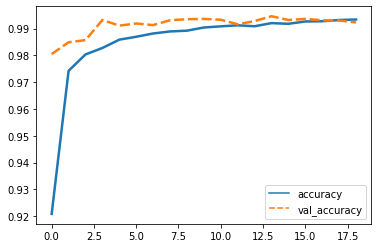

In [ ]:
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);


Grafico de Loss con Data Augmentation: 

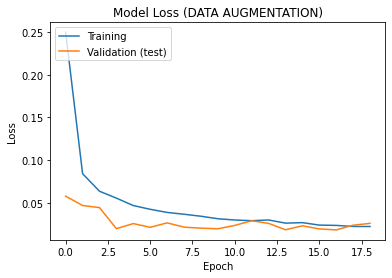

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (DATA AUGMENTATION)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation (test)'], loc='upper left')
plt.show()

Guardar pesos en archivo h5 conteniendo los parametros optimos del modelo:

In [ ]:
#cnn.save_weights('DeberFinal.h5')
#cnn.save()

Se tiene al final mejor accuracy y loss en los conjuntos de validacion al usar data Augmentation. El conjunto de training va a empeorar en razon al usar CNN pero el data augmentation ayuda a la validacion.

##Test con imagenes propias

(1, 28, 28, 1)


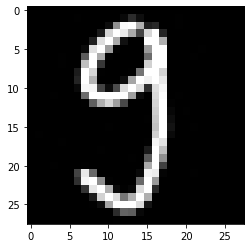

In [ ]:


files=['/content/test0.JPG','/content/test1.JPG','/content/test2.JPG','/content/test3.JPG','/content/test4.JPG'
,'/content/test5.JPG','/content/test6.JPG','/content/test7.JPG','/content/test8.JPG','/content/test9.JPG']
photos=[]
images=[]


import cv2
for i in files:
  image = cv2.imread(i,0)
  image = cv2.resize(image, (28,28))
  images.append(image)
  photos.append(image.reshape(-1,28,28,1))
plt.imshow(images[9],cmap='gray')
print(photos[0].shape)


In [ ]:
CATEGORIES = ["0","1","2","3","4","5","6","7","8","9"]
for data in photos:
  prediction = cnnAg.predict(data)
  index=np.argmax(prediction)
  print(CATEGORIES[index])
  

1/1 [==============================] - 0s 66ms/step
0
1/1 [==============================] - 0s 19ms/step
1
1/1 [==============================] - 0s 16ms/step
2
1/1 [==============================] - 0s 15ms/step
3
1/1 [==============================] - 0s 15ms/step
4
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 17ms/step
6
1/1 [==============================] - 0s 16ms/step
7
1/1 [==============================] - 0s 16ms/step
8
1/1 [==============================] - 0s 18ms/step
9
